In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a SARSA agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool, int]) -> int:
        """Choose an action using epsilon-greedy strategy.

        Returns:
            action: 0 (stand) or 1 (hit)
        """
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            q = self.q_values[obs]
            max_q = np.max(q)
            best_actions = np.flatnonzero(np.isclose(q, max_q))
            return int(np.random.choice(best_actions))

    def update(
        self,
        obs: tuple[int, int, bool, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool, int],
        next_action: int,
    ):
        """Update Q-value based on experience.

        This is the heart of SARSA: learn from (state, action, reward, next_state, next_action)
        """
        # Use next_action chosen from the current policy on-policy
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[obs][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [2]:
from env import BlackjackEnv

# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable) 
n_episodes = 1_000_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration

# Create environment and agent
env = BlackjackEnv(num_decks=2, tc_min=-20, tc_max=20)
tc_min, tc_max = env.tc_min, env.tc_max
print(tc_min)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

-20


In [3]:
import numpy as np
from tqdm import tqdm  # Progress bar

n_buckets = env.observation_space.spaces[3].n
hist_start = np.zeros(n_buckets, dtype=np.int64)

for episode in tqdm(range(n_episodes)):
    # Start a new hand
    obs, info = env.reset()
    tc_idx = obs[3]                     # integer in [0, n_buckets-1]
    hist_start[tc_idx] += 1
    # Agent chooses action (initially random, gradually more intelligent)
    action = agent.get_action(obs)
    done = False

    # Play one complete hand
    while not done:
        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_action = agent.get_action(next_obs) if not done else 0

        # Learn from this experience
        agent.update(obs, action, reward, done, next_obs, next_action)

        obs, action = next_obs, next_action

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()

# Pretty print
labels = np.arange(tc_min, tc_max + 1)  # map index -> actual TC
for b, c in zip(labels, hist_start):
    print(f"TC {b:+d}: {c}")
print("coverage %:", np.round(100 * hist_start / hist_start.sum(), 2))

100%|██████████| 1000000/1000000 [01:07<00:00, 14900.20it/s]

TC -20: 0
TC -19: 2
TC -18: 5
TC -17: 17
TC -16: 45
TC -15: 108
TC -14: 224
TC -13: 453
TC -12: 899
TC -11: 1689
TC -10: 2943
TC -9: 5277
TC -8: 8494
TC -7: 13485
TC -6: 21648
TC -5: 30725
TC -4: 45812
TC -3: 63075
TC -2: 90269
TC -1: 145007
TC +0: 110224
TC +1: 151562
TC +2: 98576
TC +3: 67136
TC +4: 48303
TC +5: 33191
TC +6: 23199
TC +7: 14650
TC +8: 9462
TC +9: 5916
TC +10: 3526
TC +11: 2057
TC +12: 1065
TC +13: 526
TC +14: 240
TC +15: 119
TC +16: 47
TC +17: 16
TC +18: 5
TC +19: 3
TC +20: 0
coverage %: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-02 2.000e-02
 5.000e-02 9.000e-02 1.700e-01 2.900e-01 5.300e-01 8.500e-01 1.350e+00
 2.160e+00 3.070e+00 4.580e+00 6.310e+00 9.030e+00 1.450e+01 1.102e+01
 1.516e+01 9.860e+00 6.710e+00 4.830e+00 3.320e+00 2.320e+00 1.460e+00
 9.500e-01 5.900e-01 3.500e-01 2.100e-01 1.100e-01 5.000e-02 2.000e-02
 1.000e-02 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]


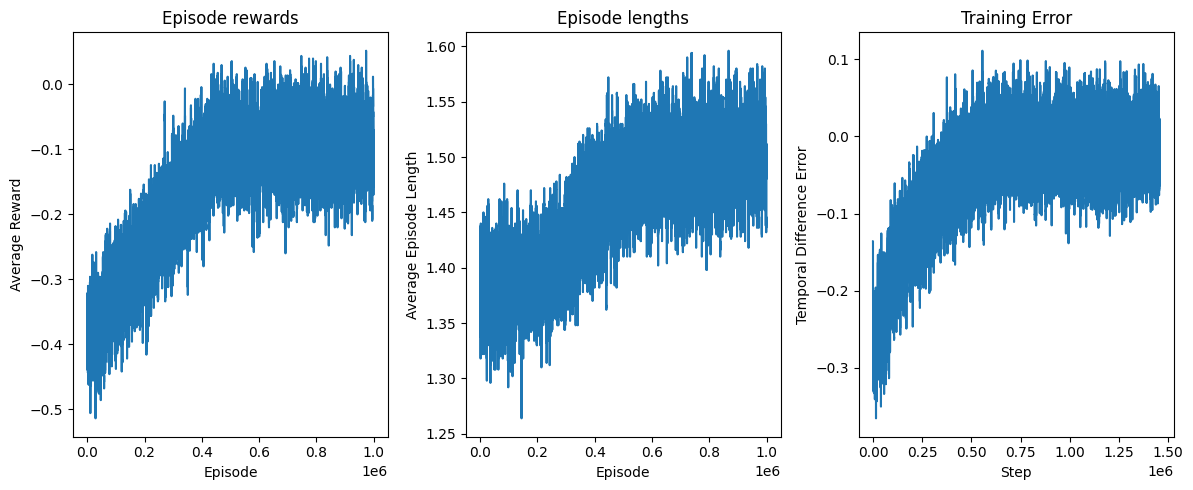

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
# Save as PNG into your Drive folder
plt.savefig('SARSA_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)

    # Restore original epsilon
    agent.epsilon = old_epsilon

    win_rate = np.mean(np.array(total_rewards) > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# Test your agent
test_agent(agent, env, num_episodes=50000)

Test Results over 50000 episodes:
Win Rate: 42.6%
Average Reward: -0.059
Standard Deviation: 0.952


In [7]:
np.set_printoptions(suppress=True, precision=6) 
ret_sum = np.zeros(env.observation_space.spaces[3].n)
ret_n   = np.zeros_like(ret_sum)

# Temporarily disable exploration for testing
old_epsilon = agent.epsilon
agent.epsilon = 0.0  # Pure exploitation

for _ in range(200_000):
    obs, _ = env.reset()
    tc_idx = obs[3]
    done = False; G = 0.0
    while not done:
        a = agent.get_action(obs)
        obs, r, term, trunc, _ = env.step(a)
        G += r; done = term or trunc
    ret_sum[tc_idx] += G; ret_n[tc_idx] += 1
avg = np.divide(ret_sum, ret_n, where=ret_n>0)

agent.epsilon = old_epsilon
print(avg)

[ 0.        1.        0.        0.       -0.181818 -0.5      -0.268293
 -0.1375   -0.213793 -0.085409 -0.069132 -0.116012 -0.122807 -0.12006
 -0.054457 -0.093802 -0.088686 -0.074309 -0.079679 -0.079058 -0.077162
 -0.037285 -0.016544 -0.033751 -0.026407 -0.009364 -0.033369 -0.021343
 -0.017647 -0.018551  0.034328 -0.062874  0.076142 -0.041667  0.020833
  0.090909 -0.714286 -0.2       0.       -1.        0.      ]


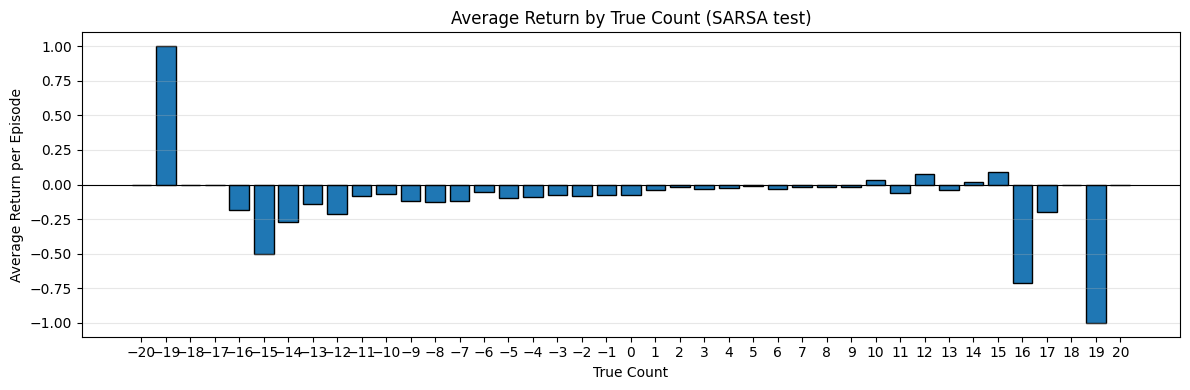

In [8]:
# Plot average return per true-count bucket (requires `avg`, `tc_min`, `tc_max` in scope)
import numpy as np
from matplotlib import pyplot as plt

# If `avg` isn't defined, tell the user to run the test cell that computes it.
if 'avg' not in globals():
    raise NameError("`avg` not found. Run the test cell that computes `avg` first (the cell that runs 200_000 episodes and computes `avg`).")

# Labels map index -> actual true count value
labels = np.arange(tc_min, tc_max + 1)

y = np.asarray(avg, dtype=float)
# Mask buckets with no samples (NaN)
valid = ~np.isnan(y)
if not np.any(valid):
    raise ValueError("No valid buckets to plot (all buckets have no samples). Run the test cell that populates `avg` first.")

x = labels[valid]
y = y[valid]

plt.figure(figsize=(12,4))
plt.bar(x, y, color='tab:blue', edgecolor='k')
plt.axhline(0, color='black', linewidth=0.8)
plt.xlabel('True Count')
plt.ylabel('Average Return per Episode')
plt.title('Average Return by True Count (SARSA test)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(labels)  # show all TC ticks for clarity
plt.tight_layout()
plt.show()